<a href="https://colab.research.google.com/github/AnmolBansal10/Sales-Forecasting-and-Predictions/blob/main/sales_forecast_RandomForestRegressor_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [5]:
data = pd.read_csv('train.csv', parse_dates=['date'])
data.set_index('date', inplace=True)

In [6]:
# Feature Engineering: Creating a supervised learning problem
data['sales_diff'] = data['sales'].diff()
data.dropna(inplace=True)

In [7]:
def create_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# Creating supervised data for the last 24 months
supervised_data = create_supervised(data['sales_diff'], 12)

In [8]:
# Splitting data into train and test sets
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]

In [9]:
print(train_data)
print(test_data)

            sales_diff  sales_diff  sales_diff  sales_diff  sales_diff  \
date                                                                     
2013-01-02         0.0         0.0         0.0         0.0         0.0   
2013-01-03        -2.0         0.0         0.0         0.0         0.0   
2013-01-04         3.0        -2.0         0.0         0.0         0.0   
2013-01-05        -1.0         3.0        -2.0         0.0         0.0   
2013-01-06        -3.0        -1.0         3.0        -2.0         0.0   
...                ...         ...         ...         ...         ...   
2014-02-02        15.0        -2.0         5.0        -2.0         3.0   
2014-02-03         5.0        15.0        -2.0         5.0        -2.0   
2014-02-04       -16.0         5.0        15.0        -2.0         5.0   
2014-02-05         3.0       -16.0         5.0        15.0        -2.0   
2014-02-06        -4.0         3.0       -16.0         5.0        15.0   

            sales_diff  sales_diff  s

In [10]:
# Scaling features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [11]:
print(train_data)
print(test_data)

[[0.20670391 0.20670391 0.20670391 ... 0.20670391 0.20670391 0.18435754]
 [0.18435754 0.20670391 0.20670391 ... 0.20670391 0.20670391 0.24022346]
 [0.24022346 0.18435754 0.20670391 ... 0.20670391 0.20670391 0.19553073]
 ...
 [0.02793296 0.26256983 0.37430168 ... 0.16201117 0.38547486 0.24022346]
 [0.24022346 0.02793296 0.26256983 ... 0.26256983 0.16201117 0.16201117]
 [0.16201117 0.24022346 0.02793296 ... 0.15083799 0.26256983 0.29608939]]
[[ 0.29608939  0.16201117  0.24022346  0.02793296  0.26256983  0.37430168
   0.18435754  0.26256983  0.18435754  0.24022346  0.02793296  0.15083799
   0.17318436]
 [ 0.17318436  0.29608939  0.16201117  0.24022346  0.02793296  0.26256983
   0.37430168  0.18435754  0.26256983  0.18435754  0.24022346  0.02793296
   0.29608939]
 [ 0.29608939  0.17318436  0.29608939  0.16201117  0.24022346  0.02793296
   0.26256983  0.37430168  0.18435754  0.26256983  0.18435754  0.24022346
   0.06145251]
 [ 0.06145251  0.29608939  0.17318436  0.29608939  0.16201117  0.24

In [12]:
# Splitting data into input and output
x_train, y_train = train_data[:, 1:], train_data[:, 0]
x_test, y_test = test_data[:, 1:], test_data[:, 0]

In [13]:
# Reshape target data for compatibility
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [14]:
# Creating a DataFrame to store predictions
sales_dates = data.index[-13:].to_series().reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates, columns=['date'])

In [15]:
# Actual sales for the last 13 months
actual_sales = data['sales'].values[-13:]

Training Random Forest Regressor Model

In [16]:
# Train the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)
rf_model.fit(x_train, y_train.ravel())
rf_predict = rf_model.predict(x_test)

In [17]:
# Inverse transform to original scale
rf_predict = scaler.inverse_transform(np.concatenate((rf_predict.reshape(-1, 1), x_test), axis=1))[:, 0]


In [18]:
# Calculating predicted sales
result_list = []
for index in range(len(rf_predict)):
    result_list.append(rf_predict[index] + actual_sales[index])

rf_predict_series = pd.Series(result_list, name='rf_prediction')

In [19]:
# Merging with prediction DataFrame
predict_df = predict_df.join(rf_predict_series)

In [20]:
print(predict_df)

         date  rf_prediction
0  2014-02-06          59.68
1  2014-02-07          46.99
2  2014-02-08          67.62
3  2014-02-09          35.94
4  2014-02-10          43.17
5  2014-02-11          37.58
6  2014-02-12          54.46
7  2014-02-13          66.41
8  2014-02-14          38.20
9  2014-02-15          51.21
10 2014-02-16          75.02
11 2014-02-17          26.23
12 2014-02-18            NaN


MODEL EVALUATION

In [24]:
# Model Evaluation
'''
rf_mse = np.sqrt(mean_squared_error(actual_sales[1:], rf_predict[:-1]))
rf_mae = mean_absolute_error(actual_sales[1:], rf_predict[:-1])
rf_r2 = r2_score(actual_sales[1:], rf_predict[:-1])

print(f"Random Forest MSE: {rf_mse}")
print(f"Random Forest MAE: {rf_mae}")
print(f"Random Forest R2 Score: {rf_r2}")
'''
# Model Evaluation
# Model Evaluation
rf_mse = np.sqrt(mean_squared_error(actual_sales[-12:], rf_predict))
rf_mae = mean_absolute_error(actual_sales[-12:], rf_predict)
rf_r2 = r2_score(actual_sales[-12:], rf_predict)

print(f"Random Forest MSE: {rf_mse}")
print(f"Random Forest MAE: {rf_mae}")
print(f"Random Forest R2 Score: {rf_r2}")


Random Forest MSE: 49.260779615565696
Random Forest MAE: 47.54083333333333
Random Forest R2 Score: -32.77151974485357


Plotting actual sales vs predicted sales



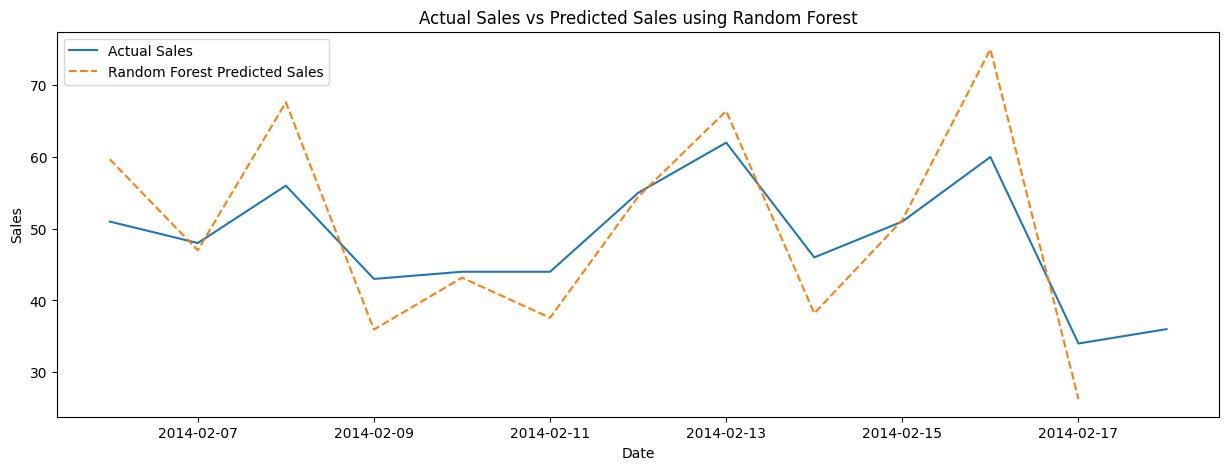

In [25]:
# Plotting actual sales vs predicted sales
plt.figure(figsize=(15, 5))
plt.plot(data.index[-13:], actual_sales, label='Actual Sales')
plt.plot(predict_df['date'], predict_df['rf_prediction'], label='Random Forest Predicted Sales', linestyle='--')
plt.title('Actual Sales vs Predicted Sales using Random Forest')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()